In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

In [2]:
# size of training data set
training_size = 100
# dimension of data sets
n = 2
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
# load iris and normalise
x = preprocessing.normalize(iris.data)
x1_train = x[0:49, :] # class A
x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [3]:
sv = Statevector.from_label('0' * n)

In [4]:
def final_circuit(circuit, data, params):
    angle_y = ((np.pi-data[0])*(np.pi-data[1]))
    angle_z = ((np.pi-data[2])*(np.pi-data[3]))
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i],i)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i+2],i)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i+4],i)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i+6],i)

In [5]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 2  # num of trainable params
for i in range(100):
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,8)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,8)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Layer4Hard/quantum_loss_hard_layer4_%d.npy' %i
    f2 = 'Layer4Hard/opt_params_hard_layer4_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546  ]
[0.24929365523210487, 0.21408689388784294, 0.2130975235134873, 0.20657718376676834, 0.18670081701407554, 0.1613280100266101, 0.13876807843828903, 0.12353142070547865, 0.11597867876034518, 0.11329641004957186, 0.11174581030365735, 0.10880257829699248, 0.10392826811251225, 0.09805843404297997, 0.09260796030145187, 0.08864897835462282, 0.08651853247860741, 0.08584095588596985, 0.08582066112944318, 0.08561297323942756, 0.08462076832187487, 0.082649305499581, 0.07990762509186786, 0.07687761693796241, 0.07410643119711727, 0.07200103603243949, 0.07069837695584169, 0.07005298280569143, 0.06973662049336482, 0.06939739518194683, 0.06880247607948937, 0.06790516552967078, 0.06682213121999149, 0.0657497205087052, 0.06486717750119282, 0.06426826815976483, 0.06394190319133428, 0.06379821640203644, 0.06371848138113957, 0.06360208397688971, 0.06339193644180102, 0.06307469593193157, 0.06266481553728759, 0.

[0.36878228383440004, 0.2384064734675251, 0.17397715424034801, 0.14576717389811286, 0.13311800085785574, 0.12334674567460162, 0.11075291082517703, 0.09518307794543213, 0.07948072411622797, 0.06711122268815306, 0.0605726751574192, 0.06055322229704922, 0.06575027884147985, 0.07336308880088085, 0.08015200448938781, 0.08363272713220873, 0.08282610509494223, 0.07828111232233925, 0.07153739007776418, 0.06439416814355814, 0.05829074159819193, 0.053962535393906004, 0.05141123531189964, 0.05012627247989005, 0.04942380058280669, 0.04875113408464618, 0.04784936300270059, 0.04674911326068598, 0.04564921678317668, 0.04476219143750683, 0.04419989977277669, 0.04393534541346638, 0.043836135815137574, 0.04373764023120353, 0.043516184653204226, 0.04313218745572209, 0.042631550937222956, 0.04211151355000362, 0.04166890705892382, 0.04135344651192459, 0.041145717874653466, 0.04096910026074335, 0.04072949690399073, 0.040363311559152286, 0.03987001798668572, 0.03931351604367833, 0.03879239542835306, 0.038394

[0.17915924228852165, 0.11923063854104742, 0.10626711453616002, 0.11186448718754499, 0.11813312700017004, 0.120370618121283, 0.11906660027329324, 0.11556544208973905, 0.11105047349697764, 0.1067803887518422, 0.10351662730551107, 0.1011001921542144, 0.09900543330823415, 0.09701524576869305, 0.0952141502532273, 0.0936493890261316, 0.09229556770141101, 0.09109488067105283, 0.08992615971584444, 0.08869045914225811, 0.08743565247641959, 0.08634130951148057, 0.08554231114770605, 0.08495987948716768, 0.08435786634177206, 0.08358448798297678, 0.08270463599982136, 0.08191443358293707, 0.08138362921644758, 0.08115550143678088, 0.08113195978769173, 0.08112502367077237, 0.08094852413033492, 0.08051170781981579, 0.0798629483945528, 0.07915740363730209, 0.0785750644160865, 0.0782410131463471, 0.0781842217628523, 0.07834152021893158, 0.07859240199135559, 0.07880488255411865, 0.07887757695009433, 0.0787691342314743, 0.07850851217260461, 0.07818160762894713, 0.07789618182780218, 0.07773729141834589, 0.

[0.6340477923729056, 0.5050926972146437, 0.4009702247860096, 0.33304119152751993, 0.29823833859784304, 0.2754284761484226, 0.2527680804000731, 0.22994129461227983, 0.20791399227880722, 0.18637464395065803, 0.1656905353567647, 0.14673211933361494, 0.1297929028059557, 0.11476945762054859, 0.10218866266526824, 0.09332649430274509, 0.08910390961595546, 0.0891466676903621, 0.09181173733938511, 0.09488745030085237, 0.09636718877275983, 0.09504942914069683, 0.09084876835395052, 0.08466683587534332, 0.07783673858003248, 0.07145046563301612, 0.06600659570825125, 0.061525786806759776, 0.05786372601753055, 0.05494783431130974, 0.052847407329100274, 0.05165425731514989, 0.05124924952705934, 0.051183310577203794, 0.050873185560100086, 0.049962062549190105, 0.048491546642970666, 0.04679117626257032, 0.045228263474688495, 0.04397705217445743, 0.04294456747164382, 0.04191607816723604, 0.04079777315167776, 0.03972387317895411, 0.038938543120742165, 0.038583512078001585, 0.03858489168392821, 0.038726033

[0.5173875061415094, 0.38065467234724715, 0.29589667747141, 0.23929824815118247, 0.19813468226773254, 0.16478358137842, 0.13591928116407723, 0.11085545063539987, 0.08982431912522401, 0.07328808190707328, 0.061574678415051744, 0.05468919133167468, 0.05231907794257149, 0.05386938738229761, 0.05845805687630682, 0.06487482019940295, 0.07160716960861359, 0.07711152421836037, 0.08023963017284834, 0.08047837190379398, 0.07792056121320949, 0.07308782817512564, 0.06672331580280913, 0.05965375166979191, 0.05272683753198375, 0.04671809079486563, 0.04216557725572093, 0.039230806018490876, 0.03770950459043981, 0.037208551786076995, 0.03734817840947193, 0.03783555286829032, 0.03842296282903809, 0.038890154088052284, 0.03911340363869104, 0.03911663817732488, 0.03901061914119645, 0.03886978067505061, 0.038667998613786204, 0.03833479089844322, 0.03783975806937725, 0.037193362679131745, 0.03640136770898213, 0.035461774974449675, 0.03440891397883357, 0.03333536674636729, 0.0323508880108811, 0.03152280192

[ 0.1762616   0.79542746  0.78306146  0.63167495 -0.92822083  0.38351516
 -0.24263812  0.03702189]
[0.1747958132327422, 0.13951845340920277, 0.11776552436092656, 0.10563926722746905, 0.09828765424754943, 0.09312759677555106, 0.08956967951404794, 0.08691507934140327, 0.08445842047887205, 0.08227321781113071, 0.08071077394780019, 0.07957306026607254, 0.07816867880436779, 0.07603276218250926, 0.07319001121067159, 0.06990894933216747, 0.06646744414837975, 0.0631037050441821, 0.06004970196073833, 0.057486453446486556, 0.055420951916680804, 0.05365406458542192, 0.051917853416212335, 0.05003705543508561, 0.04798425614560309, 0.04585469343643703, 0.04381538650499944, 0.04202654660217166, 0.04054355000549966, 0.03929672609430263, 0.03822047757373754, 0.03737894650379971, 0.036880125005869374, 0.0366722401944649, 0.03650387185889988, 0.03610496821499744, 0.03536662576786376, 0.034356558987497676, 0.03322260888498291, 0.03208697650368985, 0.03099052338904934, 0.0299281421218229, 0.028936442412192

[0.3118832124295501, 0.22514233456009822, 0.18553147250286864, 0.16670561945163095, 0.1552629882870269, 0.14541881789548872, 0.13538308858943343, 0.12553069617267723, 0.11638129050559756, 0.10752287745657652, 0.09781586422199343, 0.0868387198421287, 0.07574038638253398, 0.06645359623379718, 0.06046335605232442, 0.05811436434540431, 0.05856228762569194, 0.06020233999313201, 0.061362237230298516, 0.06096445044545986, 0.058834332498903345, 0.055546443148509664, 0.0519996567710578, 0.04899098154680716, 0.046954802707971345, 0.04590955211397342, 0.045565297981592916, 0.04550208552069947, 0.04533348990405536, 0.044810458835178264, 0.043865274501890025, 0.042608644914243266, 0.04127791851510527, 0.04013842430364811, 0.03937398869822324, 0.03902038000709082, 0.03897064363042233, 0.039038100569355014, 0.03903738664809609, 0.03884887422461134, 0.03844982098541572, 0.03790750451325875, 0.03733879507082069, 0.03685365942275764, 0.03650829005919035, 0.03628796762023318, 0.03612424449750837, 0.03593

[0.2602425401322727, 0.17009429218276098, 0.1225446963423858, 0.10208136500707354, 0.0959629853202361, 0.09549711930900001, 0.09629172363147662, 0.09706688112200344, 0.09780657976335816, 0.09831972361114173, 0.09781079292611934, 0.09543090926065594, 0.09100332675333417, 0.08517875883822684, 0.07910823401646992, 0.07400590703989231, 0.07078335152122824, 0.06979446722762815, 0.07072238028755634, 0.0726769388538448, 0.07453366663384728, 0.07538440306337846, 0.07484934916030854, 0.07310085294108515, 0.07065991103713855, 0.0681295770682654, 0.06599449050862635, 0.06453242266492235, 0.0638171227069488, 0.06376418308920305, 0.0641807707088572, 0.06480753149509959, 0.06536315360842757, 0.06560312869317474, 0.06538472870446715, 0.06471006199745927, 0.0637208853779454, 0.0626432213317321, 0.0617058362055135, 0.06106527894988802, 0.060762609089461406, 0.06072292077233019, 0.060794842252790464, 0.060814060098418124, 0.06066541508430634, 0.06031847182385022, 0.05982433166253355, 0.05927991836741952

[0.17585112109084458, 0.15163944579648955, 0.12282057385430976, 0.09978366372521358, 0.08794429346756287, 0.08322477624847735, 0.07989833821138957, 0.07690409642792112, 0.07585127821661272, 0.0777810694045082, 0.08153748175291275, 0.08436692463850005, 0.08430205930155706, 0.08139649736055117, 0.0769265006348191, 0.07219068613991095, 0.06787405073099331, 0.06405148194480743, 0.060577621898483945, 0.05747943408337921, 0.055041124439588286, 0.05354727507138138, 0.052944039683691255, 0.05276689927534263, 0.05246785817596683, 0.05185925770927705, 0.05121587815005451, 0.05093888600940618, 0.05113892500376958, 0.051539146886877295, 0.05174406125251332, 0.051548478152778514, 0.051001916194101625, 0.050284278971241755, 0.049596442219756925, 0.049099074668738994, 0.04882334073360542, 0.0486375402795867, 0.048399635622678704, 0.04813501955108644, 0.04797298746042265, 0.04793135086979743, 0.047872371718410786, 0.047683868251324035, 0.047409871756524016, 0.04717135313122017, 0.04701631830133891, 0.

[0.16251280347348862, 0.15543977149464602, 0.1463233232768779, 0.1311335716898697, 0.11956123292483922, 0.1172173770480257, 0.12219000315973652, 0.12710868089236074, 0.12730518764003584, 0.12408867131590476, 0.12112393574897803, 0.12062853759924498, 0.12206361171015584, 0.12333388834785153, 0.1228307750241243, 0.1204463409739091, 0.11726732024439404, 0.11461527698807215, 0.11315065525633912, 0.11258959532839513, 0.11220982741253592, 0.11162587736619953, 0.11102306093429352, 0.11071472404946732, 0.11063283695157866, 0.1103267647260232, 0.10942306575205486, 0.1080074333408289, 0.10653211839875017, 0.10537332677412023, 0.10448288245892419, 0.1034617900392888, 0.10196250910786299, 0.10000299605121973, 0.09789856904805275, 0.09591998467852379, 0.09403010714507692, 0.09194413149288715, 0.0894226662132454, 0.08648396125542296, 0.08335297796340367, 0.08025638867544443, 0.0772802770271596, 0.07438245208823963, 0.07149046383290429, 0.06857992931925933, 0.0656921747094543, 0.06291028367850823, 0.

[0.3151769524875879, 0.25926021638324886, 0.2191931768778279, 0.1926391042099901, 0.17445399409915202, 0.16068098038670478, 0.1489806235042376, 0.1375629350686189, 0.12605355044370803, 0.11488936208781894, 0.1038823082482155, 0.09305442938306326, 0.08323308894048209, 0.07515295227922923, 0.06915939461150955, 0.06543505377548098, 0.06397392195343797, 0.06440419655645394, 0.06599883588357115, 0.0679092976231708, 0.06944265578584925, 0.07024141619256724, 0.07038435221662998, 0.07025582135639465, 0.07016261803067997, 0.07007583518365834, 0.06981241312765313, 0.06935878342260716, 0.06886543198106376, 0.06838954624346824, 0.06777817562444029, 0.06684241751786868, 0.06554917119169759, 0.06404161164860894, 0.06256942866849348, 0.06136908922339935, 0.06053175416016234, 0.06003036691959641, 0.05985571490216665, 0.0600114584726992, 0.06038092809819183, 0.060718043352368356, 0.06082752462714579, 0.060670571427162104, 0.06029720972331777, 0.05978947513198731, 0.05924259036627411, 0.0587077212088860

[0.19389425354165638, 0.14456022864688806, 0.13159101098977766, 0.13395733475155527, 0.13628848625129783, 0.13368072884513063, 0.12814314761446494, 0.12266384894450277, 0.11808734255740772, 0.1132114277484477, 0.1068901819739688, 0.09948435371740014, 0.0924302827500148, 0.08698390542011054, 0.08334122699602217, 0.08076147995379533, 0.07846089357276065, 0.07622169276499166, 0.07431230168724721, 0.07312056558457232, 0.07282059593224827, 0.07319085919368179, 0.07365373003476158, 0.07354857678710687, 0.07248505527868422, 0.0705255019080956, 0.06809857838383458, 0.06575559817733077, 0.06392594909273475, 0.06277165270769398, 0.06218764196439637, 0.06193823383228839, 0.06183587914644029, 0.061830507852688676, 0.06196507038456687, 0.06226734630703002, 0.06267153863005315, 0.06301812501236585, 0.06312833181608712, 0.0629068800532501, 0.06240352680569261, 0.06178666039633122, 0.0612448246705109, 0.060882231648137414, 0.06067542681655302, 0.060515351329364996, 0.06029954712588789, 0.0600039272985

[0.5016159278469675, 0.38634885234558086, 0.2980210626458225, 0.23253018955865365, 0.18023158727640456, 0.13882502026140248, 0.10833141282601667, 0.0881496081823177, 0.07715921372779401, 0.07396475915217102, 0.07620499136399154, 0.07982377757615852, 0.08095288865930994, 0.07812625790086088, 0.0720911344774426, 0.06474086008406356, 0.05807879793004501, 0.0534045795675279, 0.050875552253850376, 0.049602549910092504, 0.048276039341521144, 0.04594582588957318, 0.04243110309015673, 0.038209177017115396, 0.03403552689513708, 0.030587036086673687, 0.02826617836169132, 0.02716315064173519, 0.02710264124628095, 0.02771445726800018, 0.028525212648957524, 0.02908610114405339, 0.029102259427000877, 0.02849168961613581, 0.027344988820176365, 0.025835532027778784, 0.024156138021078383, 0.02250941652683827, 0.021109985793217753, 0.020145704785856224, 0.019704883950060193, 0.019732553345533227, 0.020062311680025424, 0.02050026672671456, 0.020894449483305755, 0.021151981383055515, 0.021225305328492705,

[0.43347124369118983, 0.3099317212184469, 0.23256668279368542, 0.18804316899088577, 0.1639015358186485, 0.15016068095433863, 0.14061828007211785, 0.13238559494968305, 0.12443802721575477, 0.11644907455649196, 0.10826840146728625, 0.09984395477206853, 0.09127287980909213, 0.08278978914224226, 0.07467442394479441, 0.06713920991540713, 0.06026680967375168, 0.0540454163379826, 0.048472525081172585, 0.043627670385329664, 0.03965654475795664, 0.036698999723444675, 0.03481561940039091, 0.0339386287328199, 0.0338524491515944, 0.03420902811060556, 0.03458569143071745, 0.03458184262125857, 0.03392626589135053, 0.03255134302115858, 0.03060317150413496, 0.028386162192125013, 0.02626300810322461, 0.02454086362355314, 0.023379271167747483, 0.022754768068212704, 0.02249955988228391, 0.022392717948898806, 0.022249296725459385, 0.02196308794237257, 0.02150313957671566, 0.020893129786609337, 0.02019400036137313, 0.0194882528267988, 0.018858314955101305, 0.018363044967767108, 0.018026035214806595, 0.0178

[0.21275572952513402, 0.14183181220089588, 0.12220633647318734, 0.13202725659549594, 0.1468072171102588, 0.1524069684941705, 0.14776708803734992, 0.13706605935125885, 0.12407423472317529, 0.11157919359797576, 0.10148470829002612, 0.09476546689731832, 0.09166656912142757, 0.0918154562865092, 0.0941364988530355, 0.09686230932379213, 0.0980676586892144, 0.09662113034623067, 0.0927211007873026, 0.087579856032283, 0.08268472688052887, 0.07914761505893277, 0.07734685847637567, 0.07689945416181622, 0.07694372132513941, 0.07661053063223626, 0.07543527251991779, 0.07349511686562848, 0.07125711205886258, 0.0692798814790539, 0.06793059803342852, 0.0672297043141855, 0.06687541969427481, 0.06642725867179625, 0.06554813677756413, 0.06416941697082534, 0.06249665724573334, 0.0608764489168868, 0.05961504969568112, 0.058844152006679744, 0.05848957365954366, 0.05834212083646651, 0.058179016644931345, 0.05786474542602915, 0.05738428552208328, 0.05680959130424003, 0.056236463825702084, 0.055733529338834964

[0.7428644580994066, 0.5609835450892555, 0.45021879169337914, 0.39448293291880454, 0.3713375799814689, 0.3597585147338956, 0.34684477258385354, 0.32851324449901426, 0.3059760056341818, 0.281852035721747, 0.25784655164798215, 0.23432322085839985, 0.211123799297618, 0.18841152173308684, 0.16684217236577778, 0.147293263816547, 0.13057121488712414, 0.11725531173712024, 0.1076507032013832, 0.10177850305391319, 0.09935823530782659, 0.09978846859841621, 0.1021702206049071, 0.10541558697644537, 0.10843569665699694, 0.11034529727689565, 0.11060621087987192, 0.10906794905417189, 0.1059135081061336, 0.10154860642130975, 0.09647567979429354, 0.09118219468188866, 0.08605884570730607, 0.08135359948348805, 0.07716214699477775, 0.0734513709260299, 0.0701068666195969, 0.0669900787972781, 0.06398848934870183, 0.061045940201486334, 0.05816842034617901, 0.0554091461679366, 0.052842315186539805, 0.050536035796742054, 0.04853264495218819, 0.046840548606924715, 0.0454374789476101, 0.04428189320294485, 0.0433

[0.2831664678280006, 0.22834966103801693, 0.21733463473076003, 0.20657985054285297, 0.18505253102543, 0.1587098938346793, 0.13437984889447363, 0.11652208840015531, 0.10639905632590059, 0.10246361206120987, 0.10207398025300302, 0.10314103371368903, 0.10466336741971377, 0.10637595627375887, 0.10822152431736823, 0.1100388859463811, 0.11149082379077603, 0.1121310506909489, 0.11154551623023727, 0.10953092460360986, 0.10623892360598827, 0.10218713031317397, 0.09809311474518397, 0.09459848441617298, 0.09202493878509477, 0.0902943074088289, 0.08905669384147988, 0.08794629567276738, 0.08680189822158331, 0.08571689801965382, 0.08490258503917811, 0.08447247491922091, 0.08430664498309266, 0.08409732590507854, 0.08354228367458644, 0.0825420115154177, 0.08126071360188204, 0.08001552565380408, 0.07907714744651595, 0.07851927724026173, 0.07821325551774354, 0.07795548765265477, 0.07762186612754718, 0.07723967939438163, 0.0769411050200821, 0.0768443951504835, 0.0769506221020106, 0.07712977290167584, 0.0

[0.39026901520441704, 0.2847393672392455, 0.20971795417242248, 0.1577254186847378, 0.1226140393256843, 0.09818970648893072, 0.07909970544616085, 0.06255023596578858, 0.04889530213699241, 0.04023995698855931, 0.038383138553955275, 0.043325094582211995, 0.052765399126259174, 0.06285029076658742, 0.06989930642175761, 0.07200883779268433, 0.06947933289110342, 0.06407869257362081, 0.05791601838968475, 0.05255139740110634, 0.04857840344195471, 0.04569906408240932, 0.04316744278107075, 0.04034133688517311, 0.03705460353764435, 0.03366344511771721, 0.030812822966414275, 0.02908382340762546, 0.028698663791593196, 0.029413080567722676, 0.03063667326953696, 0.031708097299483734, 0.03217037871333645, 0.03190709695802854, 0.03110074954282001, 0.030074136852034118, 0.029112863372618182, 0.028349099101992598, 0.027744176317109737, 0.027159589476720064, 0.026466429201534886, 0.025630478674664108, 0.024731695000565306, 0.023917766795619598, 0.023325649252487174, 0.02301523060975838, 0.02294619164060051

[0.3675043726857399, 0.28890422267883115, 0.24094739209402485, 0.20776683844010851, 0.17692083430117406, 0.14458369085394057, 0.11241508462310612, 0.08408997675749136, 0.06304618489088717, 0.05127793919641006, 0.048627970101582256, 0.0525895818994177, 0.05908776752530184, 0.0642619935812114, 0.06599732944493365, 0.0641559580278349, 0.05986506634766402, 0.05468052648259833, 0.05005113360799148, 0.04702320300945128, 0.04598483553302723, 0.046502868516320586, 0.047502660183110654, 0.04783196193703297, 0.04684602976742578, 0.04459400836697747, 0.041589139093173286, 0.03847211706131451, 0.035806092113647804, 0.03400951943963303, 0.03330711265841307, 0.03362460153553609, 0.03452013229882096, 0.035337330056692866, 0.035560748711554506, 0.035057487179939444, 0.03400720502900538, 0.032690900715837856, 0.03137360244963264, 0.030289397695973677, 0.02959439002379981, 0.029266597442598165, 0.029085307959054098, 0.02876858843860584, 0.028164004410719805, 0.027325813008115714, 0.026439527900998173, 0

[0.47122099257367456, 0.3915304891793817, 0.3132289717915172, 0.2459429916850918, 0.19540064381748995, 0.16210162016241988, 0.14222155745371026, 0.1307821586691794, 0.12374796667471817, 0.11865022570078824, 0.11433252379655728, 0.11020400060323156, 0.10572216265966528, 0.10036227755226239, 0.09380089016825455, 0.0860732820004947, 0.07763285168455561, 0.06923305708841433, 0.061626857171350295, 0.055248525894861115, 0.05006489212599291, 0.045663027304502495, 0.041503483665019686, 0.03718964943554078, 0.03262335553652917, 0.028006439507106448, 0.023731090884159305, 0.020232023321472288, 0.017857970986334622, 0.016786995967483093, 0.016985201693323067, 0.01820522281019187, 0.020030203621726816, 0.021966012022778595, 0.02356097565782205, 0.02451067660360827, 0.024709363234701725, 0.024236496340817263, 0.023295030416385983, 0.022131705289283585, 0.02096756527045904, 0.01995510330421707, 0.019164091544745514, 0.018588869475814, 0.018169080866678157, 0.017819003635284866, 0.01746081366055101, 

[0.37345935859848417, 0.3132822615565436, 0.2587536640796989, 0.20745169197142443, 0.16304237954277342, 0.1298015177747215, 0.10956569594891999, 0.10067992865101995, 0.09940891366677283, 0.10236560909890173, 0.10693303364856145, 0.11085584978159341, 0.11289818973569983, 0.11320754641947245, 0.11275032370034287, 0.11228593146033933, 0.11159007888022683, 0.10979028207789633, 0.1063340176863713, 0.1013865092879246, 0.09555216657294095, 0.08945607737185272, 0.08353106040951747, 0.07802328834549135, 0.0730825145789693, 0.06882758918521763, 0.06537508054996327, 0.06285427067454774, 0.0613951382708738, 0.06105191012698251, 0.061665504398991045, 0.06276804970094498, 0.06368305052036939, 0.06381443595091008, 0.06289630031226502, 0.061041017193515214, 0.05862987440628826, 0.05614459927719591, 0.054005442768346, 0.05246608129497638, 0.05159343863105738, 0.05130963465568759, 0.051444748358680514, 0.05178053405152567, 0.052099541553558976, 0.052240380999618655, 0.052134010947756534, 0.0518030268717

[0.5066897902987704, 0.4499059601019911, 0.41243297833019105, 0.3695821395674477, 0.326747843508577, 0.29161025840982174, 0.26559122155776066, 0.24567908295034624, 0.22876640656458017, 0.21325627193762367, 0.1984857694008253, 0.18395793592570053, 0.16889815421458168, 0.15229075933980396, 0.13343261235539342, 0.11268095137941825, 0.09180703075767972, 0.07358608685392523, 0.06074164859473805, 0.05466089979795582, 0.054480467683910454, 0.05735617402544819, 0.06007190676781277, 0.06066036911204522, 0.05886471951096933, 0.05556323185206172, 0.051824572692626705, 0.04823783251655137, 0.04487638439516838, 0.04172415148928555, 0.03900207653915367, 0.03706330467939288, 0.036045712983502294, 0.035647929572501895, 0.035219593725437315, 0.034108257341032074, 0.03203510321295206, 0.029252446059479426, 0.026384453263374498, 0.02406286068846131, 0.02259675974954349, 0.021887152183215117, 0.02161665800947198, 0.02152788435612804, 0.021550644955005804, 0.02170689818563061, 0.02193901782824226, 0.022066

[0.5343125649075184, 0.3887048063428066, 0.29881507767105825, 0.23758099942875327, 0.1952273498731631, 0.16929439660699747, 0.15798230055935228, 0.15744297688893794, 0.16196169614633868, 0.16601148385294795, 0.16603765159398853, 0.16099819700492576, 0.15198416045935884, 0.1413040674974737, 0.13141748960193023, 0.12409495730176039, 0.12000646008711228, 0.118734138851042, 0.11908166033027844, 0.11954490466119225, 0.11882364571303926, 0.11621462986520163, 0.11174870905063806, 0.10607005993564891, 0.10015961064726919, 0.09501381440388712, 0.09136425289472595, 0.08950201899333755, 0.08924666075188643, 0.09005888014562728, 0.09124568043294057, 0.09217393337667203, 0.09241786942723279, 0.09181021353267439, 0.09041215251764902, 0.08843994098665425, 0.08618380564082391, 0.08393900149823161, 0.08195303513116531, 0.0803865806649228, 0.07928959286688327, 0.0786005975602922, 0.07817606384883029, 0.07784493965793823, 0.07746862682688883, 0.07698132506145089, 0.0763946001700321, 0.07576778555175949, 

[0.37977405052893076, 0.29648345615666405, 0.24301845465647828, 0.20583401182024813, 0.1841650852248437, 0.1766279186510189, 0.17870210687866003, 0.18355247947719502, 0.18529273237059532, 0.18106485563645014, 0.1708462220816139, 0.15654481031016565, 0.14090783175604002, 0.12656695046879343, 0.11540269489131252, 0.10821312601035493, 0.1046562725604862, 0.10348578796618028, 0.10306509396240145, 0.10200416319122148, 0.09966242162498135, 0.09630983266672564, 0.09289025707671535, 0.09049850212601733, 0.08979753340726083, 0.09064638148634008, 0.09216549806346752, 0.09323786407899484, 0.09310641982080044, 0.09167413677770979, 0.08940910876463311, 0.0870115435619935, 0.08504801772423409, 0.0837123746227427, 0.08280722082758649, 0.08193844999617951, 0.08078892885039239, 0.07929319859802689, 0.0776306928546102, 0.07608435114488024, 0.07486776084526743, 0.0740120111524447, 0.07336118741135136, 0.07266992895460309, 0.0717432335278664, 0.07053755902684243, 0.06917206590474534, 0.06785642674872877, 

[0.22060479745999273, 0.1880826774372174, 0.160561998365979, 0.1379484107339476, 0.12144554129114878, 0.1076543347311497, 0.09603939102559281, 0.08689123967487705, 0.08038168643179153, 0.07631451048527325, 0.07380318220787489, 0.07160061464974678, 0.06886945000622124, 0.06547678548351699, 0.0616920317498729, 0.05780377758245457, 0.054064999017294044, 0.05082159897233308, 0.04838890401598036, 0.04681310309897675, 0.04589842236819021, 0.04536934004662386, 0.044959132995287227, 0.04454464162460456, 0.04418088994590068, 0.043917509090400965, 0.04365491060043448, 0.04325478390096065, 0.04274078912678694, 0.04229700632149704, 0.04207822902592335, 0.042064438657815166, 0.04211266988334243, 0.042130067634194, 0.04216071312178571, 0.04229610458709376, 0.04253158007849641, 0.04274579018382597, 0.04281834350790273, 0.04273454674382977, 0.04256275419424433, 0.042353278601472685, 0.042093838400680164, 0.041768814074816495, 0.04142496452160165, 0.04114913891254043, 0.04099198474274041, 0.04093120823

In [13]:
loss_eqnn_d1 = np.load('Layer4Hard/quantum_loss_hard_layer4_1.npy')

In [14]:
loss_eqnn_d1.shape

(100,)

In [15]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Layer4Hard/quantum_loss_hard_layer4_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [16]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 4 Layers (Data Reuploading, Qubits = 2, Hard Model)')

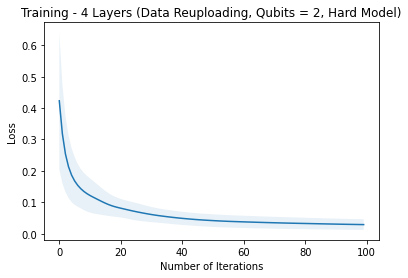

In [17]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 4 Layers (Data Reuploading, Qubits = 2, Hard Model)")

In [18]:
losseasy = np.zeros((100,100))
for i in range(100):
    file = 'Layer4Easy/quantum_loss_easy_layer4_%d.npy'%i
    losseasy[i] += np.load(file, allow_pickle=True)

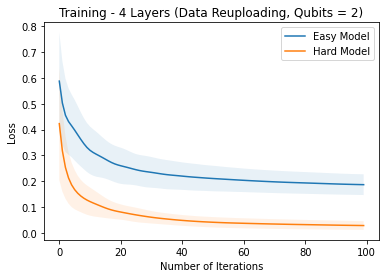

In [19]:
stddevs =[]
averages =[]
sde = np.std(losseasy, axis=0)
ave = np.average(losseasy, axis=0)
plt.plot(range(100), ave)
plt.fill_between(range(100), ave+np.array(sde), ave-np.array(sde), alpha=0.1)
stddevs.append(sde)
averages.append(ave)

plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 4 Layers (Data Reuploading, Qubits = 2)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)